In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
iris_df = pd.read_csv('iris.data', header=None, names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])
glass_df = pd.read_csv('glass.data', index_col=0, header=None, names=['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'class'])
wine_df = pd.read_csv('wine.data', header=None, names=['class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline'])

In [3]:
def split_df(df, test_size=None):
    X = df[[col for col in df if col != 'class']]
    y = df['class']
    return X, y

In [4]:
from sklearn.neighbors import KNeighborsClassifier
def knn(x, y, k = 5, weights = 'uniform', p = 2, metric = 'minkowski'):
    classifier = KNeighborsClassifier(n_neighbors = k, weights = weights, p = p, metric = metric, n_jobs = -1)
    classifier.fit(x, y)
    return classifier

In [5]:
X, y = split_df(iris_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
clf = knn(X_train, y_train)

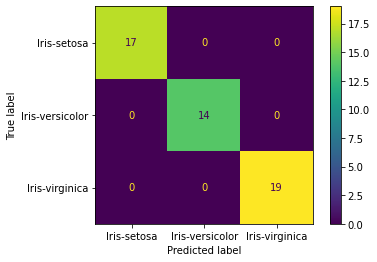

In [6]:
import sklearn.metrics as metrics
metrics.plot_confusion_matrix(clf, X_test, y_test)

In [7]:
def get_stats(X_train, X_test, y_train, y_test):
    clr = knn(X_train, y_train)
    y_pred = clr.predict(X_test)
    print('classes:', y_test.unique())
    print('precision:', metrics.precision_score(y_test, y_pred, average=None))
    print('recall:', metrics.recall_score(y_test, y_pred, average=None))
    print('f-score:', metrics.f1_score(y_test, y_pred, average=None))
    print('accuracy:', metrics.accuracy_score(y_test, y_pred))

In [8]:
get_stats(X_train, X_test, y_train, y_test)

classes: ['Iris-virginica' 'Iris-versicolor' 'Iris-setosa']
precision: [1. 1. 1.]
recall: [1. 1. 1.]
f-score: [1. 1. 1.]
accuracy: 1.0


In [9]:
from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut
def test_cv(X, y):
    for folds in [2,5,10]:
        clr = KNeighborsClassifier(n_jobs=-1)
        print(folds, 'folds:')
        print('\tno shuffle:', cross_val_score(clr, X, y, cv=KFold(folds), scoring='f1_weighted', n_jobs=-1).mean())
        print('\tshuffle:', cross_val_score(clr, X, y, cv=KFold(folds, shuffle=True), scoring='f1_weighted', n_jobs=-1).mean())
    print('leave one out:', cross_val_score(clr, X, y, cv=LeaveOneOut(), scoring='f1_weighted', n_jobs=-1).mean())

In [10]:
test_cv(X, y)

2 folds:
	no shuffle: 0.15893470790378006
	shuffle: 0.9534017971758664
5 folds:
	no shuffle: 0.9465178096757045
	shuffle: 0.9665951005528244
10 folds:
	no shuffle: 0.9634920634920634
	shuffle: 0.959030303030303
leave one out: 0.9666666666666667


Dla zbiorów Iris, Glass i Wine mieszanie danych jest konieczne, ponieważ są one posortowane według klas, co powoduje, że w jednym foldzie mogą znaleźć się obiekty tylko 1 klasy.

Wadami leave one out są jego koszt czasowy, duża wariancja wyników i to że każdy zbiór uczący jest prawie taki sam jak cały zbiór początkowy, co nie chroni przed przeuczeniem. Lepiej jest używać zwykłego folda.

In [11]:
def test_k_neighbors(X, y):
    _x = list(range(1,16))
    _y = []
    for k in _x:
        clr = KNeighborsClassifier(n_neighbors = k)
        _y.append(cross_val_score(clr, X, y, cv=KFold(shuffle=True), scoring='f1_weighted', n_jobs=-1))
    plt.boxplot(_y, labels = _x)

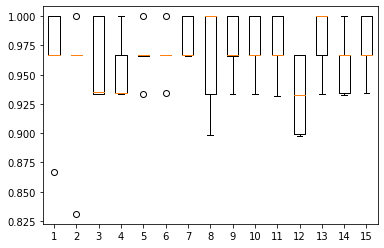

In [12]:
test_k_neighbors(X, y)

Często dla `k` parzystego dokładność jest gorsza niż dla nieparzystego, ponieważ dochodzi do sytuacji, gdzie wśród sąsiadów punktu jest tyle samo punktów jednej klasy, jak i drugiej.

In [13]:
def test_weights(X, y):
    _x = ['uniform', 'distance', 'log distance']
    _y = []
    def log_dist(x):
        return np.log(1 / 1 + x)
    for w in ['uniform', 'distance', log_dist]:
        clr = KNeighborsClassifier(weights = w)
        _y.append(cross_val_score(clr, X, y, cv=KFold(shuffle=True), scoring='f1_weighted', n_jobs=-1))
    plt.boxplot(_y, labels = _x)

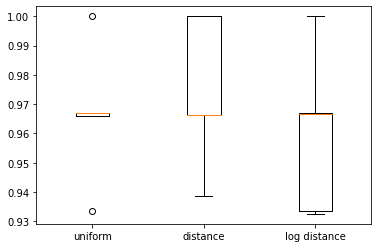

In [14]:
test_weights(X, y)

In [15]:
def test_metrics(X, y):
    _x = ['euclidean', 'manhattan', 'minkowski3']
    _y = []
    def log_dist(x):
        return np.log(1 / 1 + x)
    for p in [2,1,3]:
        clr = KNeighborsClassifier(p = p)
        _y.append(cross_val_score(clr, X, y, cv=KFold(shuffle=True), scoring='f1_weighted', n_jobs=-1))
    plt.boxplot(_y, labels = _x)

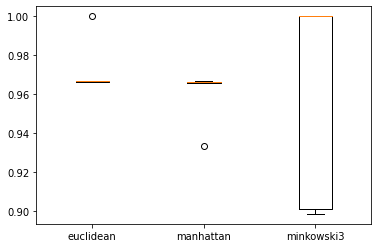

In [16]:
test_metrics(X, y)

In [17]:
from sklearn.model_selection import StratifiedKFold
def test_k_neighbors_stratify(X, y, stratify=True):
    _x = list(range(2, 12))
    _y = []
    for k in _x:
        clr = KNeighborsClassifier()
        if stratify:
            _y.append(cross_val_score(clr, X, y, cv=StratifiedKFold(n_splits=k, shuffle=True), scoring='f1_weighted', n_jobs=-1))
        else:
            _y.append(cross_val_score(clr, X, y, cv=KFold(n_splits=k, shuffle=True), scoring='f1_weighted', n_jobs=-1))
    plt.boxplot(_y, labels = _x)

## Stratyfikacja

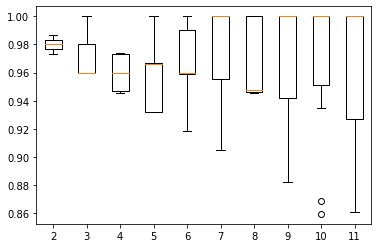

In [18]:
test_k_neighbors_stratify(X, y, False)

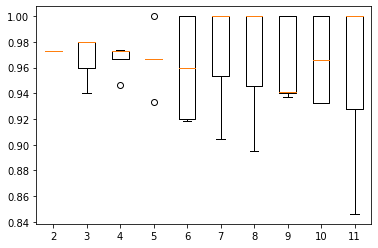

In [19]:
test_k_neighbors_stratify(X, y, True)

# Glass

In [20]:
X, y = split_df(glass_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [21]:
get_stats(X_train, X_test, y_train, y_test)

classes: [1 3 2 7 6 5]
precision: [0.5        0.76923077 1.         0.         0.         0.66666667]
recall: [0.81818182 0.66666667 0.125      0.         0.         0.8       ]
f-score: [0.62068966 0.71428571 0.22222222 0.         0.         0.72727273]
accuracy: 0.6056338028169014


In [22]:
test_cv(X, y)

2 folds:
	no shuffle: 0.19378370100882605
	shuffle: 0.619312193700766
5 folds:
	no shuffle: 0.42109301134807503
	shuffle: 0.5926650235700344
10 folds:
	no shuffle: 0.6207481443755953
	shuffle: 0.6327032945431884
leave one out: 0.6728971962616822


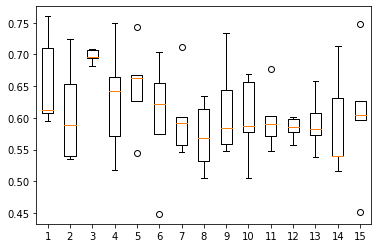

In [23]:
test_k_neighbors(X, y)

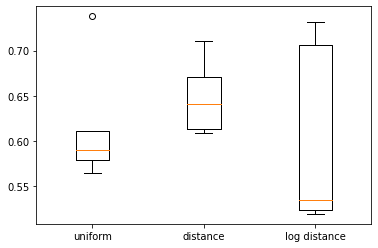

In [24]:
test_weights(X, y)

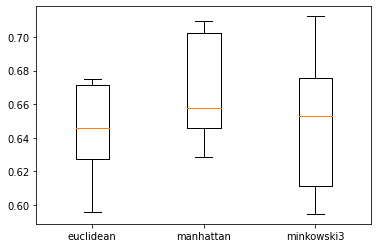

In [25]:
test_metrics(X, y)

## Stratyfikacja

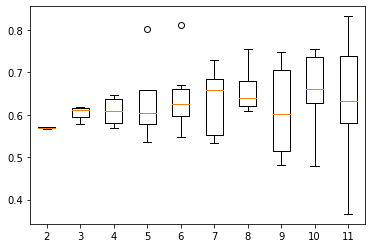

In [26]:
test_k_neighbors_stratify(X, y, False)

c:\users\kajetan\studia-mag\ai-venv\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
c:\users\kajetan\studia-mag\ai-venv\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=11.
  warnings.warn(("The least populated class in y has only %d"


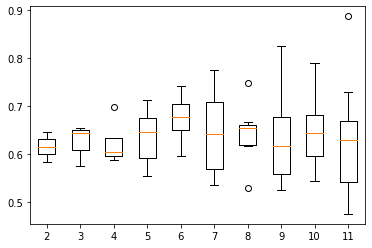

In [27]:
test_k_neighbors_stratify(X, y, True)

# Wine

In [28]:
X, y = split_df(wine_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [29]:
get_stats(X_train, X_test, y_train, y_test)

classes: [2 1 3]
precision: [0.86363636 0.8        0.35294118]
recall: [0.95       0.61538462 0.46153846]
f-score: [0.9047619  0.69565217 0.4       ]
accuracy: 0.6949152542372882


In [30]:
test_cv(X, y)

2 folds:
	no shuffle: 0.2554655517812037
	shuffle: 0.7059680830869044
5 folds:
	no shuffle: 0.673603653652538
	shuffle: 0.676222101263509
10 folds:
	no shuffle: 0.7309527506932836
	shuffle: 0.6811323643676584
leave one out: 0.6966292134831461


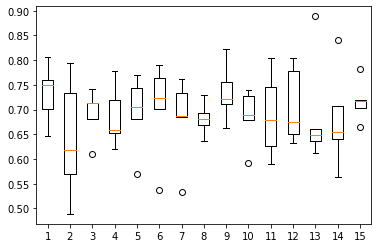

In [31]:
test_k_neighbors(X, y)

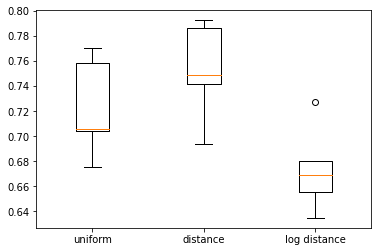

In [32]:
test_weights(X, y)

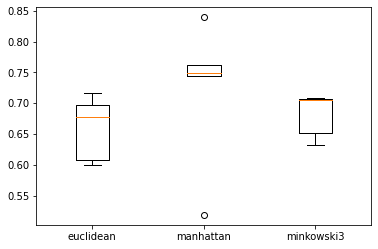

In [33]:
test_metrics(X, y)

## Stratyfikacja

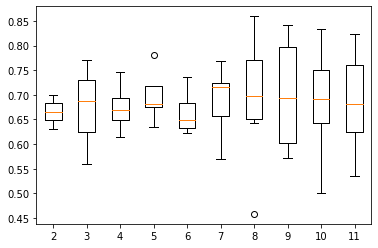

In [34]:
test_k_neighbors_stratify(X, y, False)

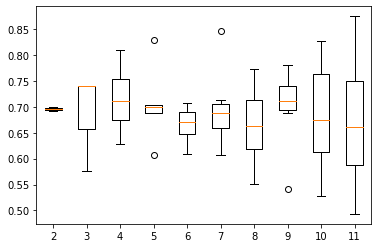

In [35]:
test_k_neighbors_stratify(X, y, True)